# Iris Dataset Clustering
Lburgueno

Start by downloading the dataset, using the code provided by [(1)](https://archive.ics.uci.edu/dataset/53/iris)

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

# metadata
print(iris.metadata)

# variable information
print(iris.variables)


{'uci_id': 53, 'name': 'Iris', 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris', 'data_url': 'https://archive.ics.uci.edu/static/public/53/data.csv', 'abstract': 'A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.\n', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 150, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1936, 'last_updated': 'Tue Sep 12 2023', 'dataset_doi': '10.24432/C56C76', 'creators': ['R. A. Fisher'], 'intro_paper': {'title': 'The Iris data set: In search of the source of virginica', 'authors': 'A. Unwin, K. Kleinman', 'published_in': 'Significance, 2021', 'year': 2021, 'url': 'https://www.semanticscholar.org/paper/4599862ea877863669a6a8e63a3c707a787d5d7e', 'doi': '1740-9713.01589'}, 'add

In [ ]:
X

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


We can see there are three classes

In [ ]:
y.nunique()

class    3
dtype: int64

## Correlation Matrix

In [ ]:
import seaborn as sns

In [ ]:
corr = X.corr()

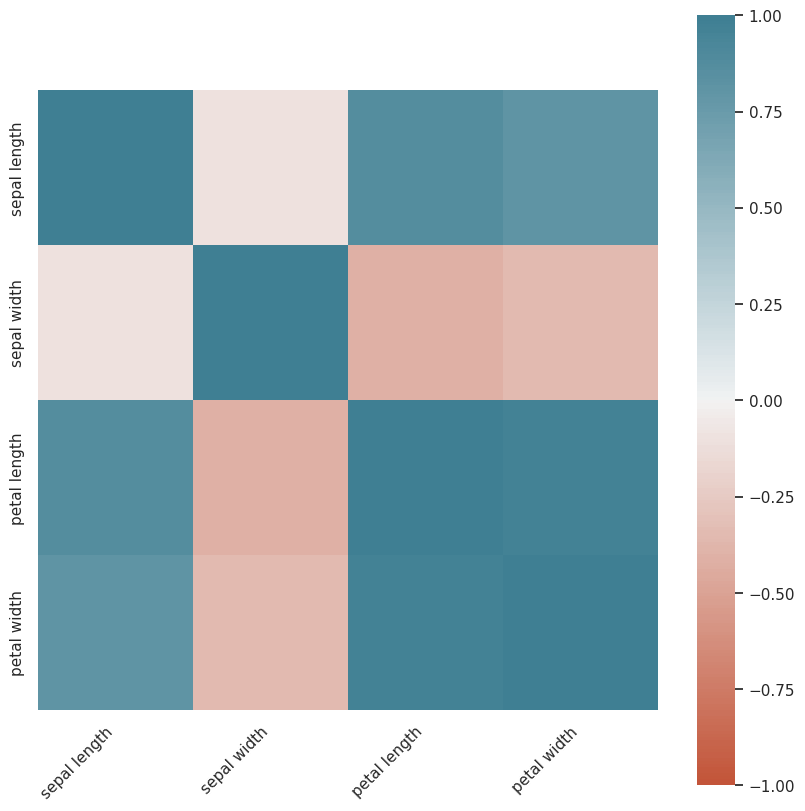

In [ ]:
sns.set(style="darkgrid")

sns.set(rc={'figure.figsize':(10,10)})

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0, annot = False,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Clustering

In [ ]:
!pip install kneed

In [ ]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

### Elbow method

In [ ]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

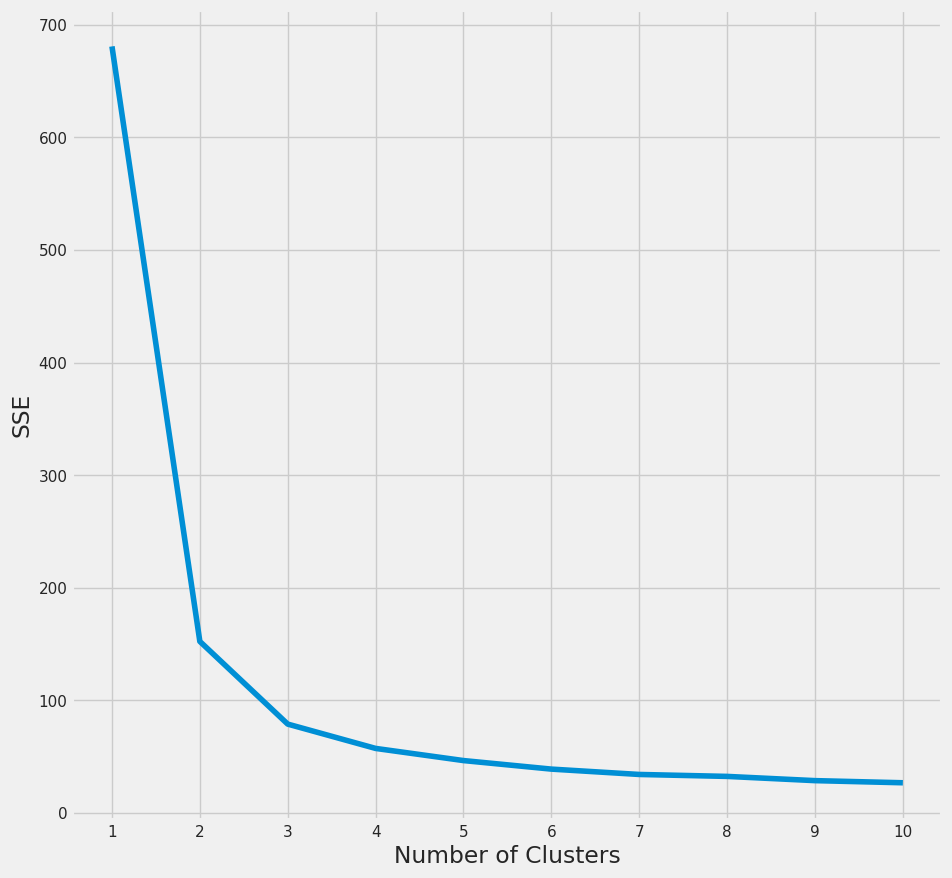

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

So we can see that **according to the elbow method, 3 is the optimal number of clusters to use** (just as the real classes from the dataset)

### Silhouette Coefficients

In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

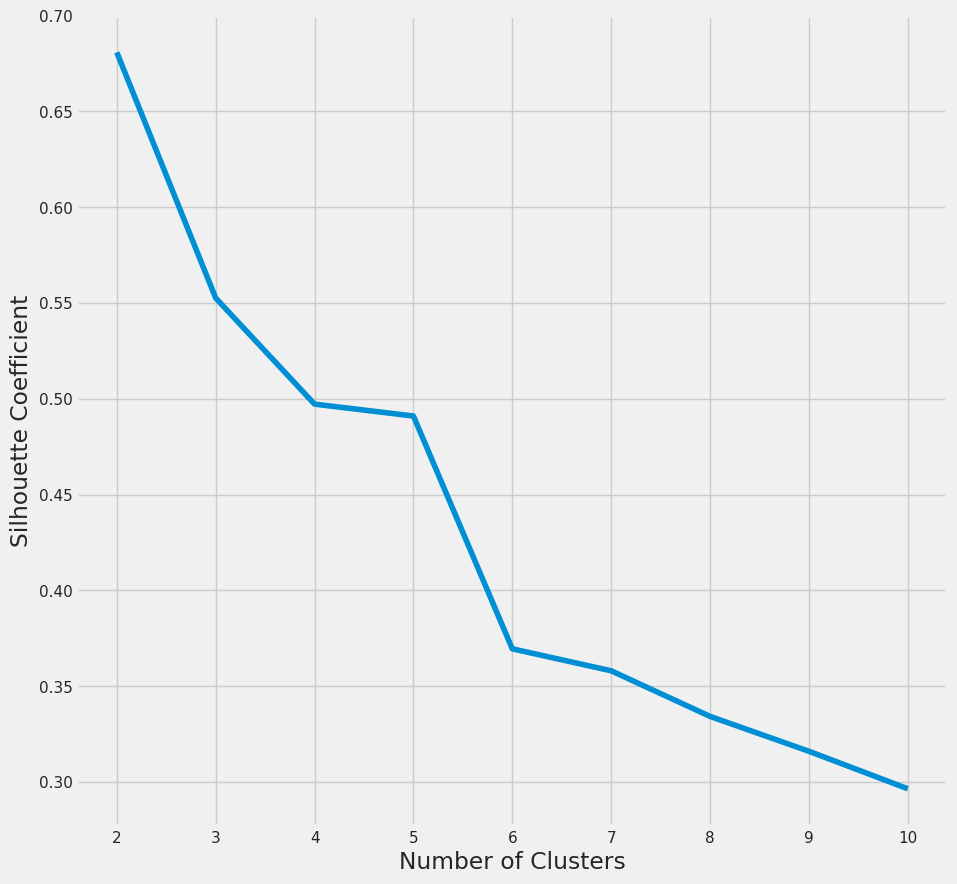

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

**According to the silhouette coefficients, the best k is 2**

In order to plot in 2 dimensions we will use PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc_1', 'pc_2'])

pca.explained_variance_ratio_

array([0.92461621, 0.05301557])

**Let's make the clustering using k=3 then, since it still has the second best silhouette coefficient and was selected by the elbow method**

In [ ]:
# Clustering k=3
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(X)

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]

Let's convert the y (classes) to numbers

In [ ]:
y_categorical = pd.Categorical(y["class"]).codes

In [ ]:
ydf = pd.DataFrame(y_categorical, columns = ["class"])
ydf

,class
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


In [ ]:
df_target = pd.DataFrame(kmeans.labels_, columns = ['target'])
finalDf = pd.concat([principalDf,df_target,ydf], axis = 1)
finalDf

,pc_1,pc_2,target,class
0,-2.684207,0.326607,1,0
1,-2.715391,-0.169557,1,0
2,-2.889820,-0.137346,1,0
3,-2.746437,-0.311124,1,0
4,-2.728593,0.333925,1,0
...,...,...,...,...
145,1.944017,0.187415,2,2
146,1.525664,-0.375021,0,2
147,1.764046,0.078519,2,2
148,1.901629,0.115877,2,2


In [ ]:
finalDf.groupby(['target']).mean()

,pc_1,pc_2,class
target,,,
0,0.674439,-0.313909,1.225806
1,-2.640841,0.190520,0.000000
2,2.374389,0.261484,1.947368


Now let's make the plot to see the clustering

In [ ]:
# Transform the centroids with PCA so they can be seen in the graph
pca_centroids = pca.fit_transform(centroids)
cen_x = [i[0] for i in pca_centroids]
cen_y = [i[1] for i in pca_centroids]

Text(0, 0.5, 'PC_2')

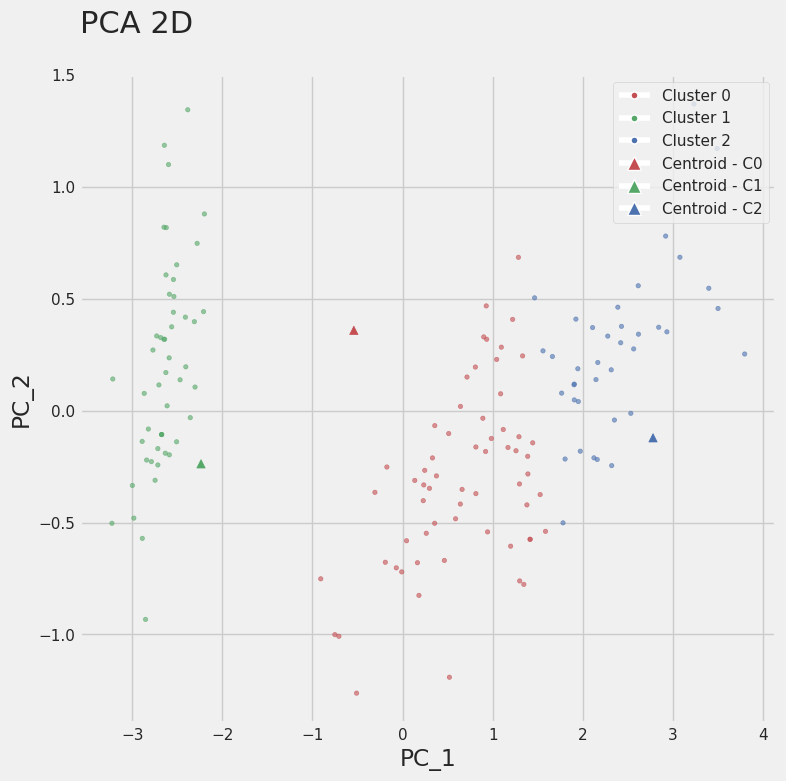

In [ ]:
colors = ['r', 'g', 'b']
finalDf['c'] = finalDf.target.map({0:colors[0], 1:colors[1], 2:colors[2]})


from matplotlib.lines import Line2D
fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(finalDf.pc_1, finalDf.pc_2, c=finalDf.c, alpha = 0.6, s=10)
# create a list of legend elemntes

## centroids
cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i),
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]

plt.scatter(cen_x, cen_y, c=["r", "b", "g"], marker="^")

## markers / records
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i),
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
legend_elements.extend(cent_leg)
# plot legend
plt.legend(handles=legend_elements, loc='upper right')
# title and labels
plt.title('PCA 2D\n', loc='left', fontsize=22)
plt.xlabel('PC_1')
plt.ylabel('PC_2')

In [ ]:
ynew = np.reshape(np.array(y), (150,))
targetnew = np.reshape(np.array(df_target), (150,))

In [ ]:
print("Adjusted Rand Index for KMeans: %0.3f"
          % metrics.adjusted_rand_score(ynew, targetnew))

Adjusted Rand Index for KMeans: 0.730


## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Let's make a plot to see the points in space

<Axes: >

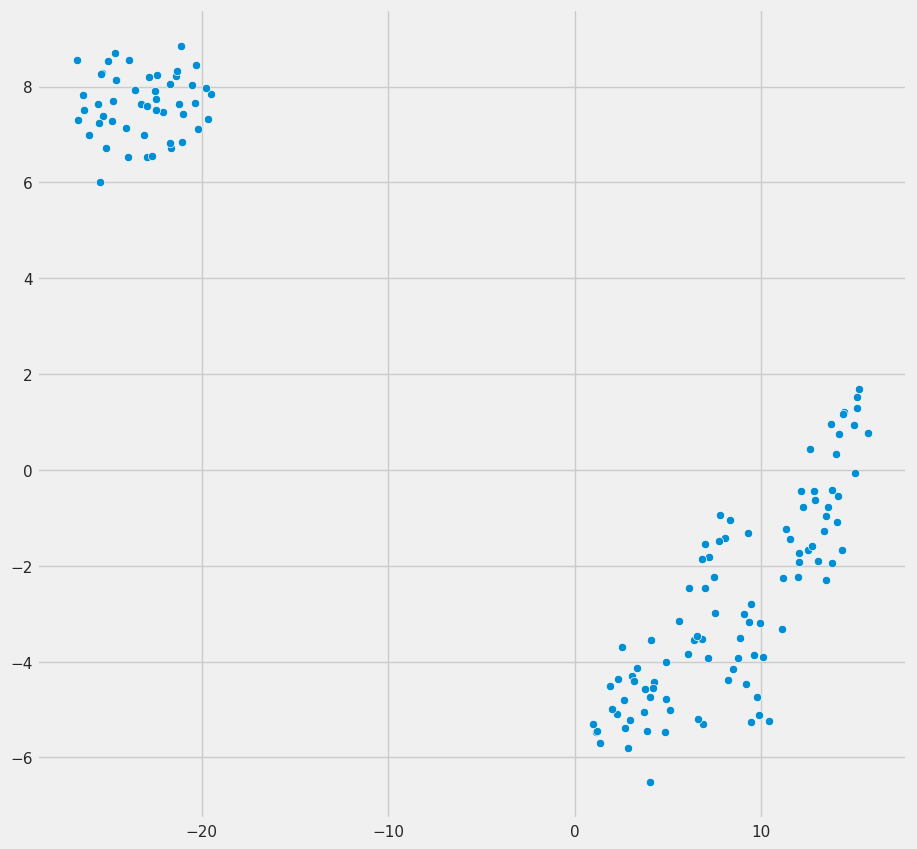

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE()
df_sample_tsne = tsne.fit_transform(X)

sns.scatterplot(x=df_sample_tsne[:,0], y=df_sample_tsne[:,1], legend='full')

Now using colors to see the classes

<Axes: >

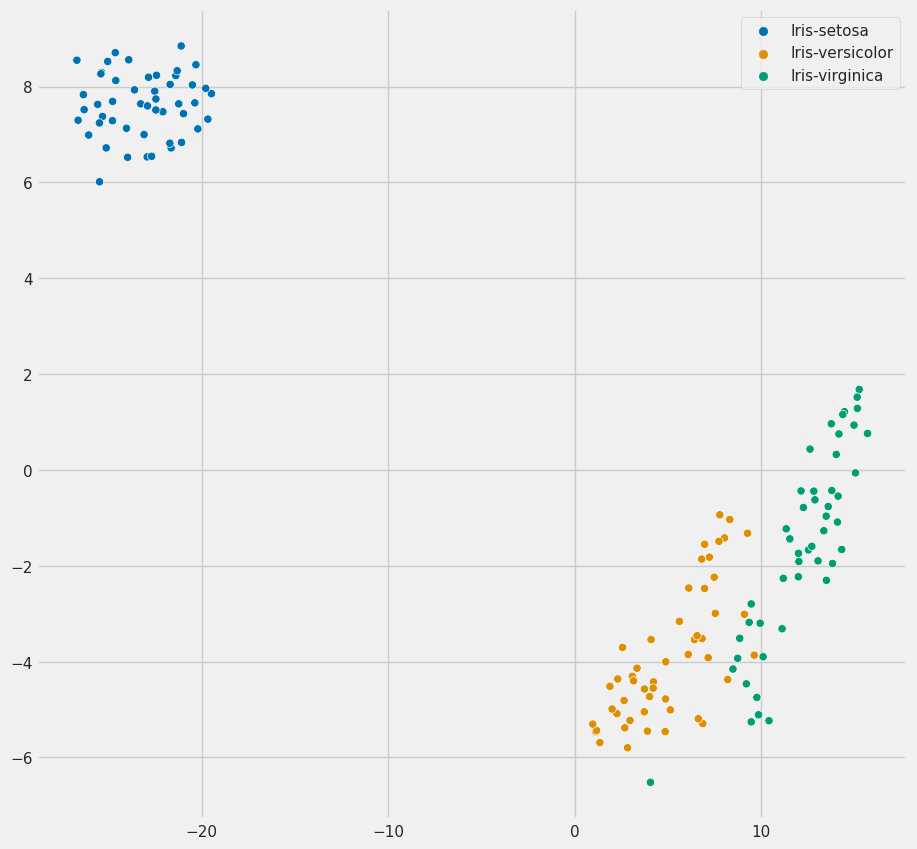

In [ ]:
sns.scatterplot(x=df_sample_tsne[:,0], y=df_sample_tsne[:,1], hue=ynew, legend='full', palette="colorblind")

Build the function for DBSCAN

In [ ]:
# Building the clustering model
def apply_dbscan(eps_value, min_samples_value, metric_distance, df, df_tsne, true_label):
    db_default = DBSCAN(eps = eps_value, min_samples = min_samples_value, metric = metric_distance).fit(df)
    labels = db_default.labels_

    ynew = np.reshape(np.array(y), (150,))

    sns.scatterplot(x=df_tsne[:,0], y=df_tsne[:,1], hue=labels, legend='full', palette='colorblind')

    core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
    core_samples_mask[db_default.core_sample_indices_] = True
    labels = db_default.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(true_label, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(true_label, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(true_label, labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(true_label, labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(true_label, labels))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(df, labels))

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

In [ ]:
# Normalizing the data so that the data
# approximately follows a Gaussian distribution
df_sample_normalized = normalize(df_scaled)

# Converting the numpy array into a pandas DataFrame
df_sample_normalized = pd.DataFrame(df_sample_normalized)

# Renaming the columns
df_sample_normalized.columns = X.columns

df_sample_normalized.head()

,sepal length,sepal width,petal length,petal width
0,-0.387617,0.444156,-0.577230,-0.565052
1,-0.519284,-0.056769,-0.609353,-0.596498
2,-0.579648,0.141360,-0.584998,-0.549365
3,-0.633543,0.044764,-0.540137,-0.552152
4,-0.411600,0.508921,-0.540264,-0.528866


Since we have 4 dimensions, let's choose minPoints = 8 as it's a good rule of thumb to have it be 2*D [(1)](https://sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/#:~:text=Details%20of%20determining%20DBSCAN%20parameters%201%201%29%20k-distance,5%20Python%20Example%20for%20selecting%20Epsilon%20%28%CE%B5%29%20), and for now we'll keep an epsilon of 0.2 just to test

Estimated number of clusters: 3
Estimated number of noise points: 81
Homogeneity: 0.607
Completeness: 0.625
V-measure: 0.616
Adjusted Rand Index: 0.525
Adjusted Mutual Information: 0.608
Silhouette Coefficient: 0.215


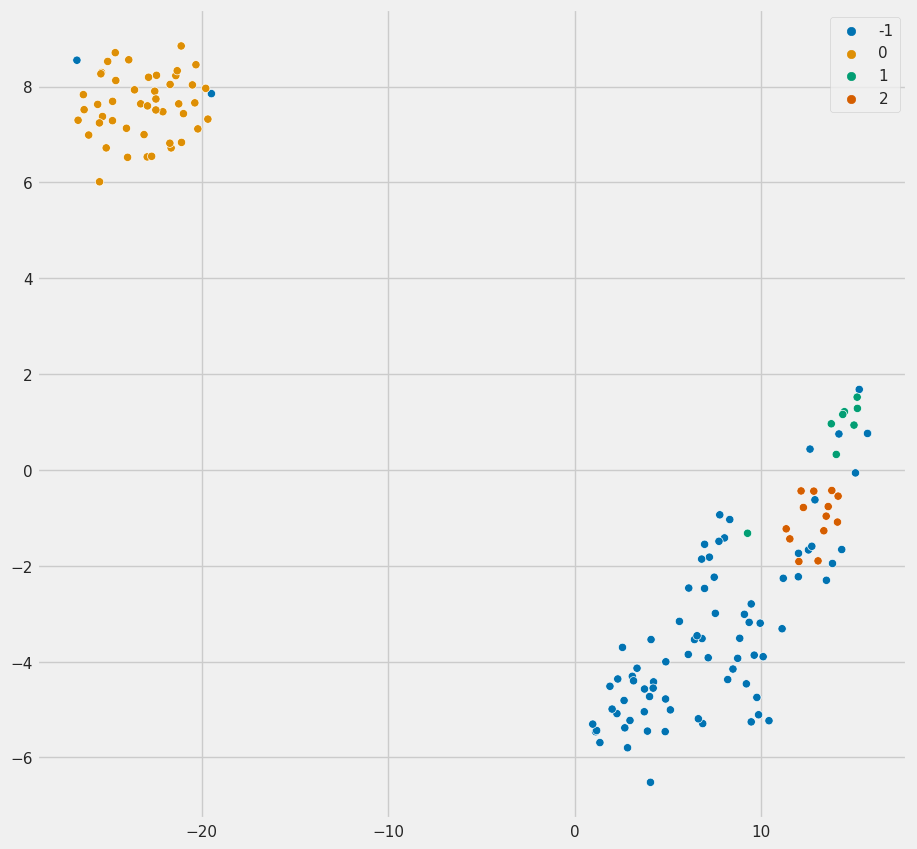

In [ ]:
apply_dbscan(0.2, 8, 'euclidean', df_sample_normalized, df_sample_tsne, ynew)

Let's get an epsilon value

In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=8)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

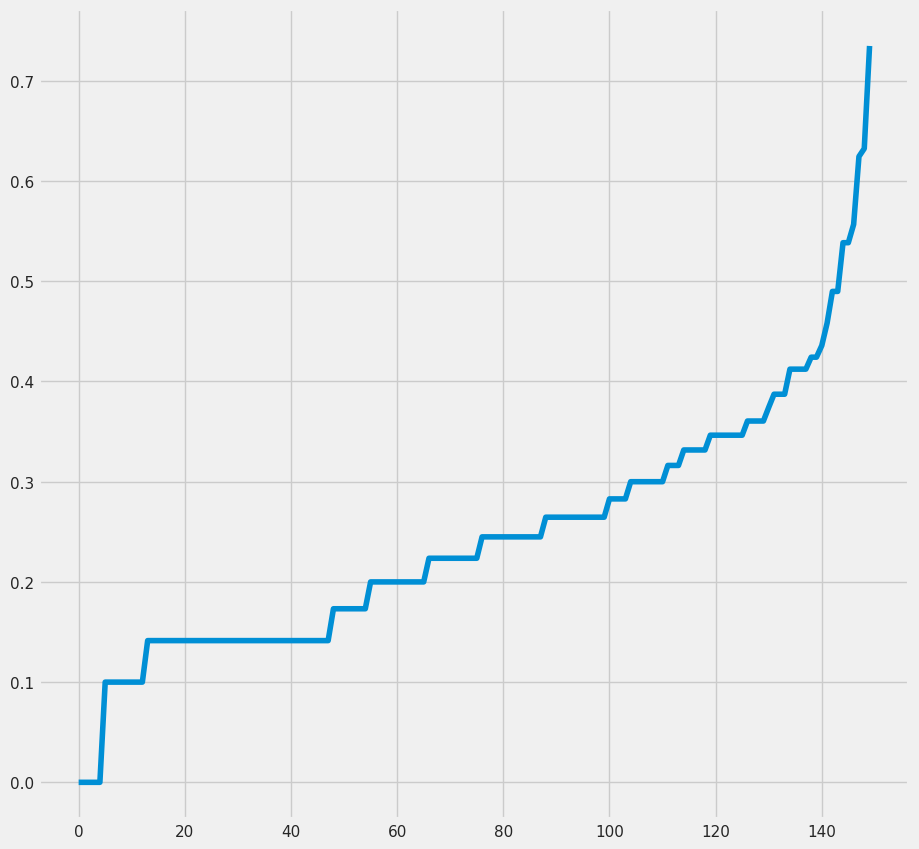

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

According to the graph, the elbow seems to be around 0.4 so that should be the optimal value, let's perform DBSCAN with epsilon = 0.4 and nmin = 8

Estimated number of clusters: 2
Estimated number of noise points: 9
Homogeneity: 0.577
Completeness: 0.760
V-measure: 0.656
Adjusted Rand Index: 0.544
Adjusted Mutual Information: 0.651
Silhouette Coefficient: 0.412


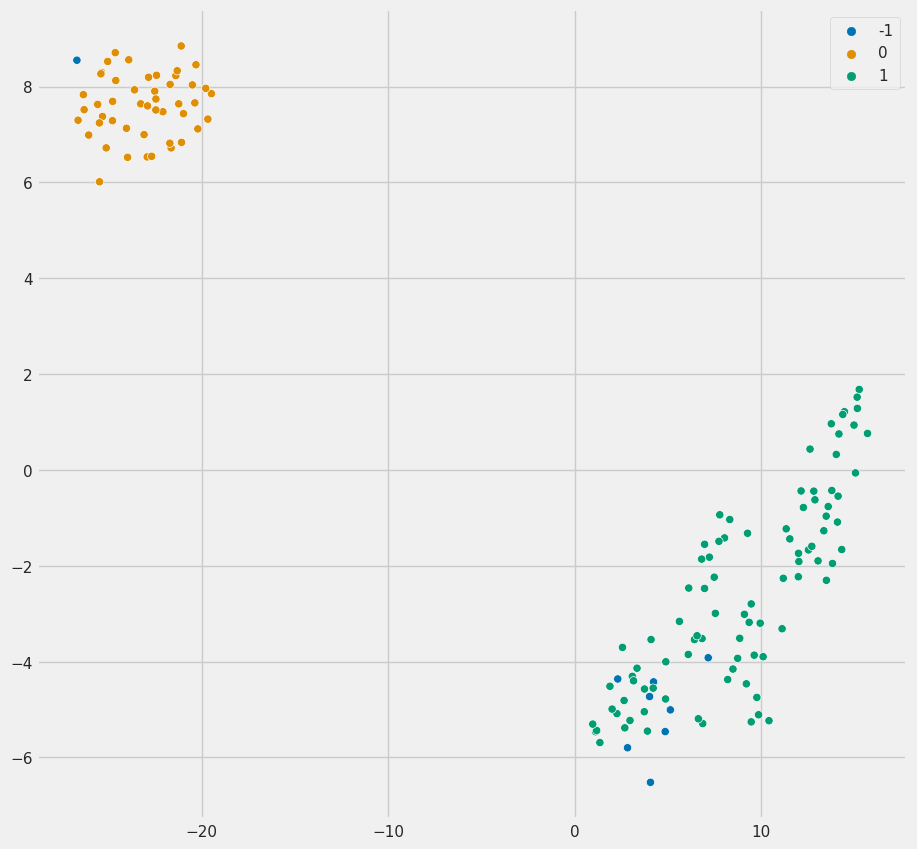

In [ ]:
apply_dbscan(0.4, 8, 'euclidean', df_sample_normalized, df_sample_tsne, ynew)

We can see it got better Rand Index and Silhouette Coefficient, so the parameters used were **nmin = 8, epsilon=0.4**

Since the KMeans algorithm got a Rand Index of 0.730 and a Silhouette coefficient of ~0.55 and DBSCAN got a Rand Index of 0.544 and a Silhouette Coefficient of 0.412, we can say that **this dataset obtains better cluster when using the KMeans algorithm**